# Potato Disease Classification

This notebook is the tutorial clone and has been updated to use this project's folder layout:
- Data source: `data/PlantVillage`
- Split output: `training/dataset/{train,val,test}`
- Saved artifacts (model + class names): `saved_models/`

Note: This notebook has been adapted to save the trained H5 model and class names into the project's `saved_models` directory.

In [12]:
# Project-specific paths and setup
from pathlib import Path
import json

# Root of the repository (adjust if your workspace is different)
ROOT = Path(r"C:/Learn Programming/Machine Learning/potato_disease")
DATA_ROOT = ROOT / 'data' / 'PlantVillage'  # original dataset location
SPLIT_DIR = ROOT / 'training' / 'dataset'   # where train/val/test will be created/expected
SAVED_MODELS = ROOT / 'saved_models'
SAVED_MODELS.mkdir(parents=True, exist_ok=True)
SAVED_H5 = SAVED_MODELS / 'potato_disease_model.h5'
CLASS_NAMES_PATH = SAVED_MODELS / 'class_names.json'

print('ROOT:', ROOT)
print('DATA_ROOT:', DATA_ROOT)
print('SPLIT_DIR:', SPLIT_DIR)
print('SAVED_H5:', SAVED_H5)
print('CLASS_NAMES_PATH:', CLASS_NAMES_PATH)

ROOT: C:\Learn Programming\Machine Learning\potato_disease
DATA_ROOT: C:\Learn Programming\Machine Learning\potato_disease\data\PlantVillage
SPLIT_DIR: C:\Learn Programming\Machine Learning\potato_disease\training\dataset
SAVED_H5: C:\Learn Programming\Machine Learning\potato_disease\saved_models\potato_disease_model.h5
CLASS_NAMES_PATH: C:\Learn Programming\Machine Learning\potato_disease\saved_models\class_names.json


If you haven't already split the PlantVillage dataset into train/val/test folders, the cell below will use `splitfolders` to create `training/dataset/train`, `training/dataset/val`, and `training/dataset/test`. This is optional if you already have those folders.

In [11]:
# Optional: split the dataset into train/val/test under `training/dataset`
# Requires: pip install split-folders
try:
    import splitfolders
except Exception as e:
    print('splitfolders not installed. Run: pip install split-folders')

if not SPLIT_DIR.exists():
    print('Splitting dataset from', DATA_ROOT, 'into', SPLIT_DIR)
    # Convert to strings for splitfolders API
    splitfolders.ratio(str(DATA_ROOT), output=str(SPLIT_DIR), seed=1337, ratio=(0.8, 0.1, 0.1))
else:
    print('Split dataset already exists at', SPLIT_DIR)

Split dataset already exists at C:\Learn Programming\Machine Learning\potato_disease\training\dataset


Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

### Import all the Dependencies

In [10]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Import data into tensorflow dataset object

Used splitfolders tool to split dataset into training, validation and test directories.

$ pip install split-folders

$ splitfolders --ratio 0.8 0.1 0.1 -- ./training/PlantVillage/


In [13]:
# Image size and channels
IMAGE_SIZE = 256
CHANNELS = 3

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
        str(SPLIT_DIR / 'train'),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse",
)

Found 1721 images belonging to 3 classes.


In [15]:
train_generator.class_indices

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

In [7]:
# Save class names so the API can map predictions back to labels
import json
class_names = list(train_generator.class_indices.keys())
CLASS_NAMES_PATH.write_text(json.dumps(class_names))
print('Saved class names to', CLASS_NAMES_PATH)

Saved class names to C:\Learn Programming\Machine Learning\potato_disease\saved_models\class_names.json


In [8]:
class_names = list(train_generator.class_indices.keys())
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [17]:
count=0
for image_batch, label_batch in train_generator:
#     print(label_batch)
    print(image_batch[0])
    break
#     count+=1
#     if count>2:
#         break

[[[0.5000583  0.5160138  0.5119576 ]
  [0.55932105 0.5826367  0.575328  ]
  [0.6433382  0.6589453  0.6710267 ]
  ...
  [0.65410566 0.65410566 0.7011645 ]
  [0.6545712  0.6545712  0.70163   ]
  [0.6547674  0.6547674  0.7018263 ]]

 [[0.50200945 0.5167032  0.5144359 ]
  [0.5514842  0.57429653 0.5668119 ]
  [0.6381742  0.65463305 0.66446626]
  ...
  [0.65180445 0.65180445 0.69886327]
  [0.651339   0.651339   0.6983978 ]
  [0.65087354 0.65087354 0.69793236]]

 [[0.5075949  0.52089226 0.5209522 ]
  [0.54450244 0.5663838  0.5593647 ]
  [0.6274687  0.6448585  0.6523645 ]
  ...
  [0.6479106  0.6479106  0.6949694 ]
  [0.6474452  0.6474452  0.694504  ]
  [0.647138   0.647138   0.6941969 ]]

 ...

 [[0.43137258 0.43921572 0.49803925]
  [0.4306     0.43844312 0.49726668]
  [0.42966908 0.43751222 0.49633577]
  ...
  [0.58431375 0.5921569  0.6431373 ]
  [0.58431375 0.5921569  0.6431373 ]
  [0.58192486 0.589768   0.64234096]]

 [[0.42374322 0.43158635 0.49040988]
  [0.42209515 0.4299383  0.4887618 ]


In [18]:
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory(
        str(SPLIT_DIR / 'val'),
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 215 images belonging to 3 classes.


In [19]:
test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
        str(SPLIT_DIR / 'test'),
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 216 images belonging to 3 classes.


In [20]:
for image_batch, label_batch in test_generator:
    print(image_batch[0])
    break

[[[0.7399344  0.7124834  0.675752  ]
  [0.74340594 0.71226436 0.68827295]
  [0.75198966 0.712774   0.7085857 ]
  ...
  [0.77710193 0.7574941  0.77318037]
  [0.77740735 0.7577995  0.7734858 ]
  [0.77771276 0.7581049  0.7737912 ]]

 [[0.7402398  0.7127888  0.67544657]
  [0.7418789  0.71165353 0.6858297 ]
  [0.75321126 0.7139956  0.7088911 ]
  ...
  [0.77853405 0.7589262  0.7746125 ]
  [0.7776179  0.75801    0.7736963 ]
  [0.7767016  0.7570938  0.77278006]]

 [[0.7405452  0.71309423 0.67514116]
  [0.7403518  0.71104276 0.68338645]
  [0.7544329  0.71521723 0.7091965 ]
  ...
  [0.76559013 0.7459823  0.76166856]
  [0.7640631  0.7444553  0.76014155]
  [0.76253605 0.7429282  0.7586145 ]]

 ...

 [[0.5426255  0.5034098  0.5073314 ]
  [0.5520931  0.51287735 0.5167989 ]
  [0.56156063 0.52234495 0.5262665 ]
  ...
  [0.57381797 0.5306807  0.5542101 ]
  [0.6274475  0.58431023 0.60783964]
  [0.52734625 0.484209   0.5077384 ]]

 [[0.6369111  0.5976954  0.601617  ]
  [0.6433247  0.6041089  0.6080305 ]


## Building the Model

In [21]:
# Build a simple CNN model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names) if 'class_names' in globals() else 3

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

C:\Learn Programming\Machine Learning\potato_disease\myenv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,742,979 (14.28 MB)

 Trainable params: 3,742,979 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
# Dataset sample counts (computed)
print('Train samples:', getattr(train_generator, 'samples', 'unknown'))
print('Validation samples:', getattr(validation_generator, 'samples', 'unknown'))
print('Test samples:', getattr(test_generator, 'samples', 'unknown'))

Train samples: 1721
Validation samples: 215
Test samples: 216


In [25]:
# Helpful info: batch size and steps (optional)
print('Train batch_size:', train_generator.batch_size if hasattr(train_generator, 'batch_size') else 'unknown')
print('Validation batch_size:', validation_generator.batch_size if hasattr(validation_generator, 'batch_size') else 'unknown')

Train batch_size: 32
Validation batch_size: 32


In [26]:
history = model.fit(
    train_generator,
    steps_per_epoch=47,
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=6,
    verbose=1,
    epochs=20,
)

C:\Learn Programming\Machine Learning\potato_disease\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 683ms/step - accuracy: 0.5972 - loss: 0.9822 - val_accuracy: 0.7396 - val_loss: 0.5803
Epoch 2/20
 7/47 ━━━━━━━━━━━━━━━━━━━━ 21s 536ms/step - accuracy: 0.8272 - loss: 0.5041

C:\Learn Programming\Machine Learning\potato_disease\myenv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.8214 - loss: 0.4986 - val_accuracy: 0.8333 - val_loss: 0.4484
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 628ms/step - accuracy: 0.8524 - loss: 0.3776 - val_accuracy: 0.8698 - val_loss: 0.2966
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.8795 - loss: 0.2866 - val_accuracy: 0.9010 - val_loss: 0.2708
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 618ms/step - accuracy: 0.9078 - loss: 0.2204 - val_accuracy: 0.9479 - val_loss: 0.1705
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9643 - loss: 0.1207 - val_accuracy: 0.9375 - val_loss: 0.1711
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 591ms/step - accuracy: 0.9506 - loss: 0.1479 - val_accuracy: 0.9167 - val_loss: 0.1980
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9420 - loss: 0.1340 - val_accuracy: 0.9219 - val_loss: 0.1971
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 597ms/step - accuracy: 0.9686 - loss: 0.0858 - val_accuracy: 0.9688 - 

In [27]:
scores = model.evaluate(test_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step - accuracy: 0.9722 - loss: 0.0785


In [28]:
scores

[0.07847125083208084, 0.9722222089767456]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [29]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [30]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 47}

In [31]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

20

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9821822047233582,
 0.49862220883369446,
 0.3775693476200104,
 0.28661754727363586,
 0.2203538566827774]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [36]:
val_acc

[0.7395833134651184,
 0.8333333134651184,
 0.8697916865348816,
 0.9010416865348816,
 0.9479166865348816,
 0.9375,
 0.9166666865348816,
 0.921875,
 0.96875,
 0.9270833134651184,
 0.96875,
 0.9479166865348816,
 0.9635416865348816,
 0.96875,
 0.953125,
 0.9791666865348816,
 0.875,
 0.8958333134651184,
 0.9375,
 0.9479166865348816]

In [37]:
acc

[0.5971943736076355,
 0.8214285969734192,
 0.8523713946342468,
 0.8794642686843872,
 0.9078156352043152,
 0.9642857313156128,
 0.9505677819252014,
 0.9419642686843872,
 0.9686038494110107,
 0.9508928656578064,
 0.959919810295105,
 0.9464285969734192,
 0.9672678709030151,
 0.9821428656578064,
 0.9706078767776489,
 0.9732142686843872,
 0.9572478532791138,
 0.9375,
 0.9532397985458374,
 0.9642857313156128]

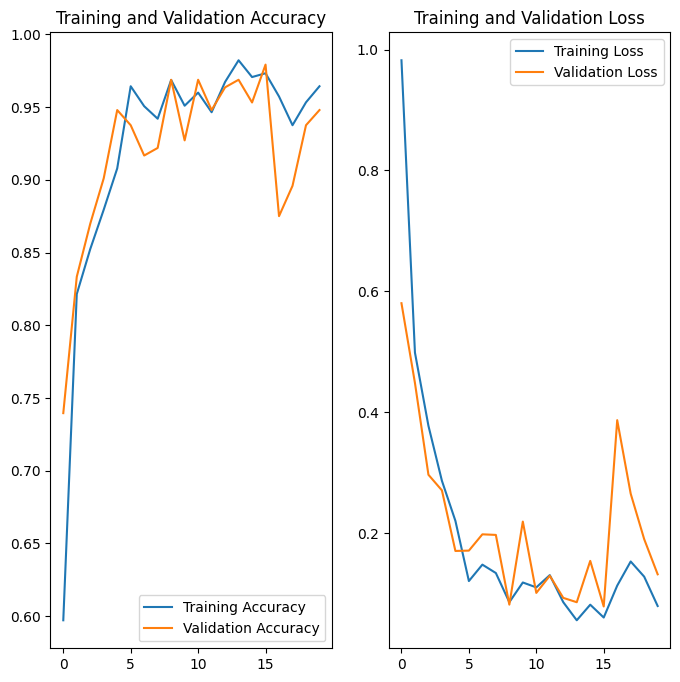

In [38]:
EPOCHS = 20

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
predicted label: Potato___Late_blight


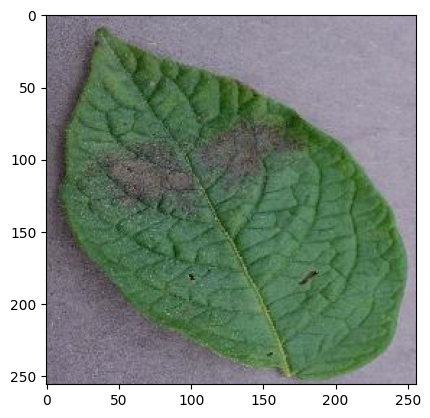

In [39]:
import numpy as np

for image_batch, label_batch in test_generator:
    first_image = image_batch[0]
    first_label = int(label_batch[0])
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label:', class_names[first_label])
    
    batch_prediction = model.predict(np.expand_dims(first_image, axis=0))
    print('predicted label:', class_names[np.argmax(batch_prediction[0])])
    
    break

### Write a function for inference

In [40]:
import numpy as np
def predict(model, img):
    # img is a numpy array scaled between 0 and 1 (as produced by ImageDataGenerator)
    img_array = np.expand_dims(img, axis=0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


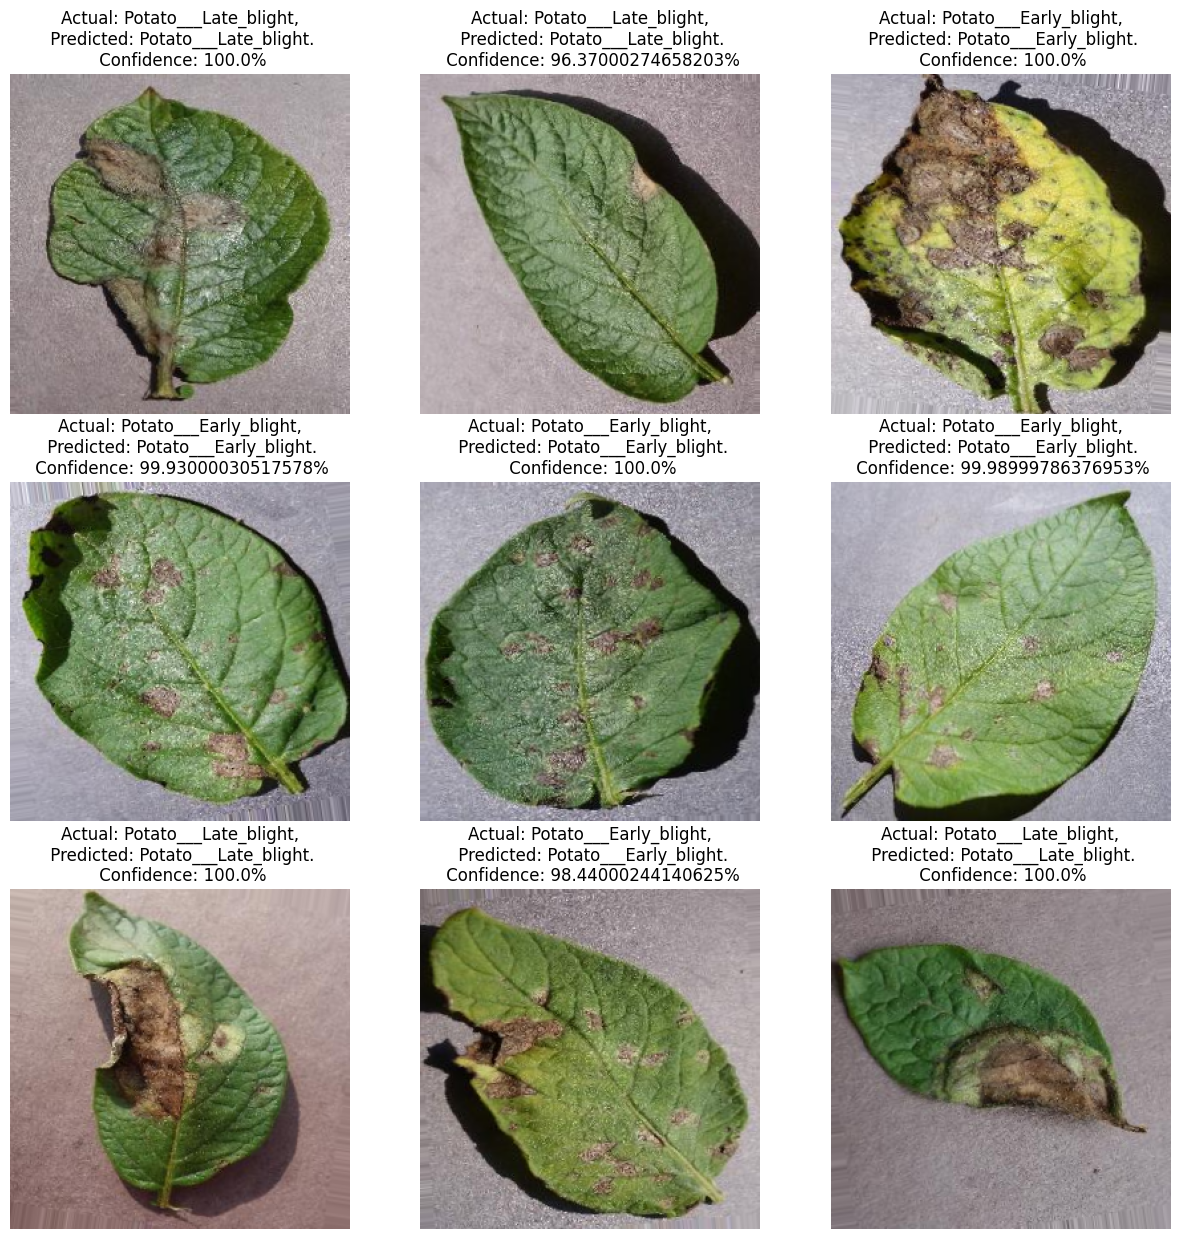

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

### Saving the Model

Save model in h5 format so that there is just one file and we can upload that to GCP conveniently

In [ ]:
# Save model to the project's saved_models so the API can load it
model.save(str(SAVED_H5))
print('Saved model to', SAVED_H5)